Project: CM4AI TEAM PROJECT
-----------------------------------------------------------------------------------------------
Goal: Perform data embedding with and without HPA Cell Segmentation and compare both results.

Created By: Rebecca Bernal August 15th, 2025


PART I: DATA EMBEDDING - WITHOUT HPA CELL SEGMENTATION
-------------------------------------

NOTES:
- SubCell was trained on individual cell crops from the Human Protein Atlas (HPA) SubCellular data, which includes immunofluorescence of 13,147 proteins of interest and 37 different human cell lines. Below are example field of view images for each of the 4 channels in the 2D HPA data: endoplasmic reticulum (yellow), nucleus (blue), microtubules (red), and protein of interest (green).
- 

In [1]:
#IN THE CONDA COMMAND CENTER WRTIE THE FOLLWOING TO CREATE A CONDA ENVIRONMENT AND ACTIVE THE ENVIRONMENT
    #conda --version
    #conda create -n cm4ai python=3.8
    #conda activate cm4ai

#install packages:
    #pip install cellmaps_pipeline
    #pip install seaborn
    #pip install -U pyDataverse

###MAKE SURE TO SELECT TO CM4AI ENVIRONMENT CREATED IN THE CONDA COMMAND CENTER

PACKAGES

In [2]:
# conda install ipykernel
# python -m ipykernel install --user --name=firstEnv
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install numpy
!pip install tqdm
!pip install joblib
!pip install requests

In [3]:
import os
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import json
from collections import Counter
import requests


EXPLORE THE DATASET

In [4]:
import os

BASE_PATH = r"C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\raw"
print(os.path.exists(BASE_PATH))  # Should be True if folder exists

True


In [5]:
BASE_PATH = r"C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\raw"
CHANNELS = ["blue", "green", "red", "yellow"]

def collect_image_paths(base_path=BASE_PATH):
    records = []
    for treatment_folder in os.listdir(base_path):
        treatment_path = os.path.join(base_path, treatment_folder)
        if not os.path.isdir(treatment_path):
            continue

        treatment = treatment_folder.split("-")[-1].lower()

        image_dict = {}
        for channel in CHANNELS:
            channel_path = os.path.join(treatment_path, channel)
            for img_path in glob(os.path.join(channel_path, "*.jpg")):
                # Extract base ID (strip _blue, _red, etc.)
                basename = os.path.basename(img_path).replace(f"_{channel}.jpg", "")
                image_dict.setdefault(basename, {"id": basename, "treatment": treatment})
                image_dict[basename][channel] = img_path

        records.extend(image_dict.values())

    return pd.DataFrame(records)

In [6]:
def load_rocrate_metadata_with_antibodies(base_path=BASE_PATH):
    metadata_records = []

    for treatment_folder in os.listdir(base_path):
        crate_path = os.path.join(base_path, treatment_folder, "ro-crate-metadata.json")
        if not os.path.isfile(crate_path):
            continue

        with open(crate_path, "r") as f:
            crate = json.load(f)

        # --- Build antibody/stain index ---
        antibody_index = {}
        for entry in crate.get("@graph", []):
            if entry.get("@type") == "BioChemEntity":
                stain_id = entry["@id"]
                identifiers = entry.get("identifier", [])
                if isinstance(identifiers, dict):
                    identifiers = [identifiers]

                id_map = {i.get("name"): i.get("value") for i in identifiers}

                antibody_index[stain_id] = {
                    "name": entry.get("name"),
                    "description": entry.get("description"),
                    "hpa_id": id_map.get("HPA Antibody ID"),
                    "ensembl": id_map.get("ENSEMBL"),
                    "uniprot": id_map.get("Uniprot"),
                    "pubchem": id_map.get("PubChem"),
                    "subcellular_location": (
                        entry.get("isLocatedInSubcellularLocation", {}).get("name")
                        if isinstance(entry.get("isLocatedInSubcellularLocation"), dict)
                        else None
                    )
                }

        # --- Process each dataset (image) entry ---
        for entry in crate.get("@graph", []):
            if entry.get("@type") != "EVI:Dataset":
                continue

            content_url = entry.get("contentUrl", "")
            filename = os.path.basename(content_url.replace("file://", "")).strip("/")
            if not filename.endswith(".jpg"):
                continue

            base_id = filename.replace(".jpg", "").rsplit("_", 1)[0]
            channel = filename.replace(".jpg", "").rsplit("_", 1)[-1].lower()

            stain_ref = entry.get("usedStain", {}).get("@id", "")
            stain_key = stain_ref.split("/")[-1].replace("stain-", "")
            ab_meta = antibody_index.get(stain_ref, {})

            metadata_records.append({
                "id": base_id,
                "channel": channel,
                "antibody_stain": stain_key,
                "antibody_name": ab_meta.get("name"),
                "antibody_hpa_id": ab_meta.get("hpa_id"),
                "antibody_ensembl": ab_meta.get("ensembl"),
                "antibody_uniprot": ab_meta.get("uniprot"),
                "antibody_pubchem": ab_meta.get("pubchem"),
                "subcellular_location": ab_meta.get("subcellular_location"),
                "cell_line": entry.get("usedCellLine", {}).get("@id", "").split("/")[-1].replace("cell-line-", ""),
                "treatment": entry.get("usedTreatment", {}).get("@id", "").split("/")[-1].replace("treatment-", ""),
                "description": entry.get("description", ""),
                "filename": filename
            })

    return pd.DataFrame(metadata_records)

In [7]:
def batch_lookup_ensembl_symbols(ensembl_ids, batch_size=1000):
    """
    Look up gene symbols from Ensembl using batched POST requests.
    Returns a dict {ensembl_id: gene_symbol}
    """
    url = "https://rest.ensembl.org/lookup/id"
    headers = {"Content-Type": "application/json"}
    id_to_symbol = {}

    for i in range(0, len(ensembl_ids), batch_size):
        batch = ensembl_ids[i:i + batch_size]
        payload = {"ids": batch}
        try:
            response = requests.post(url, headers=headers, json=payload)
            if response.status_code == 200:
                results = response.json()
                for eid, info in results.items():
                    id_to_symbol[eid] = info.get("display_name", None)
            else:
                print(f"⚠️ Error {response.status_code}: {response.text}")
        except Exception as e:
            print(f"⚠️ Request failed for batch starting at {i}: {e}")
    
    return id_to_symbol

In [8]:
def save_image_gene_node_attributes(df_merged, base_output_dir="data/raw"):
    # Filter to green channel (protein target)
    df_green = df_merged[df_merged["channel"] == "green"].copy()

    # Normalize treatment label: "control" becomes "untreated"
    df_green["treatment"] = df_green["treatment"].replace("control", "untreated")

    # Drop exact duplicates across key fields
    df_green = df_green.drop_duplicates(subset=["id", "treatment", "antibody_hpa_id", "antibody_ensembl"])

    # Group by treatment
    treatments = df_green["treatment"].dropna().unique()

    for treatment in treatments:
        df_t = df_green[df_green["treatment"] == treatment]

        df_out = pd.DataFrame({
            "name": df_t["antibody_name"],
            "represents": "ensembl:" + df_t["antibody_ensembl"].fillna(""),
            "ambiguous": df_t["antibody_hpa_id"],
            "antibody": df_t["antibody_hpa_id"],
            "filename": df_t["id"].astype(str) + "_",
            "imageurl": "no image url found"
        })

        unique_ensembl_ids = (
            df_out["represents"]
            .dropna()
            .str.replace("ensembl:", "", regex=False)
            .loc[lambda s: s.str.match(r"ENSG\d+")]  # keep only valid Ensembl Gene IDs
            .unique()
            .tolist()
        )

        ensembl_to_name = batch_lookup_ensembl_symbols(unique_ensembl_ids)

        df_out["name"] = (
            df_out["represents"]
            .str.replace("ensembl:", "", regex=False)
            .map(ensembl_to_name)
        )

        df_out["name"] = df_out["name"].fillna("NEGATIVE")

        # Save to the appropriate treatment folder
        treatment_folder = os.path.join(base_output_dir, treatment)
        os.makedirs(treatment_folder, exist_ok=True)

        out_path = os.path.join(treatment_folder, "1_image_gene_node_attributes.tsv")
        df_out.to_csv(out_path, sep="\t", index=False)

        print(f"✅ Saved: {out_path}")

In [9]:
def load_multichannel_image(row):
    """
    Loads a 4-channel immunofluorescence image from separate grayscale files.

    Args:
        row (pd.Series): A row from df_images with keys: blue, green, red, yellow.

    Returns:
        np.ndarray: H x W x 4 array with channels in the order [blue, green, red, yellow]
    """
    img_channels = []
    for ch in ["blue", "green", "red", "yellow"]:
        path = row[ch]
        img = Image.open(path).convert("L")  # Load as 8-bit grayscale
        img_array = np.array(img)
        img_channels.append(img_array)

    stacked = np.stack(img_channels, axis=-1)  # Shape: H x W x 4
    return stacked

In [10]:
def compute_stats_row(row):
    img = load_multichannel_image(row)
    results = []
    for i, ch in enumerate(CHANNELS):
        ch_data = img[..., i]
        results.append({
            "id": row["id"],
            "treatment": row["treatment"],
            "channel": ch,
            "mean": np.mean(ch_data),
            "std": np.std(ch_data),
            "min": np.min(ch_data),
            "max": np.max(ch_data),
        })
    return results

def compute_channel_stats_parallel(df, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(compute_stats_row)(row) for _, row in tqdm(df.iterrows(), total=len(df), desc="Parallel channel stats")
    )
    # Flatten nested list
    flat_results = [item for sublist in results for item in sublist]
    return pd.DataFrame(flat_results)

In [11]:
def print_summary_report(df_merged, n_jobs=4):
    print("🧬🔬 CM4AI Immunofluorescence Dataset Summary\n" + "="*45, flush=True)

    # 1. Number of treatments
    n_treatments = df_merged["treatment"].nunique()
    print(f"\n💊 Number of treatments: {n_treatments}", flush=True)
    for cond, count in df_merged["treatment"].value_counts().items():
        print(f"  - {cond}: {count} image-channel combinations", flush=True)

    # 2. Number of samples (unique image IDs) per treatment
    print("\n🧪 Number of unique samples per treatment:", flush=True)
    samples_per_treatment = (
        df_merged[["id", "treatment"]]
        .drop_duplicates()
        .groupby("treatment")
        .size()
    )
    for cond, count in samples_per_treatment.items():
        print(f"  - {cond}: {count} samples", flush=True)

    # 3. Image size distribution (parallelized)
    print("\n🖼 Image size distribution:", flush=True)

    # Reconstruct wide format for loading multichannel images
    df_channels = df_merged[["id", "channel", "filepath"]].drop_duplicates()
    df_shapes = df_channels.pivot(index="id", columns="channel", values="filepath").reset_index()
    df_treatments = df_merged[["id", "treatment"]].drop_duplicates()
    df_shapes = df_shapes.merge(df_treatments, on="id", how="left")

    def safe_load_shape(row):
        try:
            img = load_multichannel_image(row)
            return img.shape[:2]
        except Exception as e:
            print(f"  ⚠️ Error loading image for ID {row['id']}: {e}", flush=True)
            return None

    print("🔄 Computing image shapes in parallel...", flush=True)
    shapes = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(safe_load_shape)(row) for _, row in tqdm(df_shapes.iterrows(), total=len(df_shapes))
    )
    df_shapes["shape"] = shapes
    shape_counts = Counter([s for s in shapes if s is not None])
    for shape, count in shape_counts.items():
        print(f"  - {shape[0]}x{shape[1]}: {count} composite/multi-channel images", flush=True)

    # 4. Green channel antibody diversity
    green_df = df_merged[df_merged["channel"] == "green"]
    unique_green = sorted(set(green_df["antibody_hpa_id"].dropna().tolist()))
    print(f"\n🟩 Number of unique antibodies in green channel (protein target): {len(unique_green)}", flush=True)

    # 5. Red, Blue, Yellow antibody/stain names with icons
    print("\n🎯 Antibodies/stains used in other channels:", flush=True)

    channel_icons = {
        "red": "🟥",
        "blue": "🟦",
        "yellow": "🟨"
    }

    for ch in ["red", "blue", "yellow"]:
        ch_df = df_merged[df_merged["channel"] == ch]
        unique_ab = sorted(set(
            ch_df["antibody_hpa_id"].dropna().tolist() +
            ch_df["antibody_name"].dropna().tolist()
        ))
        icon = channel_icons.get(ch, "🔹")
        print(f"\n  {icon} {ch.upper()} channel antibodies/stains ({len(unique_ab)}):", flush=True)
        for ab in unique_ab:
            print(f"    - {ab}", flush=True)

    print("\n✅ Summary complete.\n", flush=True)

In [12]:
df_images = collect_image_paths()


In [13]:
with pd.option_context('display.max_colwidth', None):
    display(df_images[df_images.duplicated(subset="id", keep=False)].head())

,id,treatment,blue,green,red,yellow


In [14]:
df_meta = load_rocrate_metadata_with_antibodies()
df_images_melted = df_images.melt(
    id_vars=["id"],  # remove "treatment" here
    value_vars=["blue", "green", "red", "yellow"],
    var_name="channel",
    value_name="filepath"
)

df_merged = df_images_melted.merge(df_meta, on=["id", "channel"], how="left")

In [15]:
# TODO: Remove once image downloader integrated
save_image_gene_node_attributes(df_merged, base_output_dir=BASE_PATH)

✅ Saved: C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\raw\paclitaxel\1_image_gene_node_attributes.tsv
✅ Saved: C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\raw\untreated\1_image_gene_node_attributes.tsv
✅ Saved: C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\raw\vorinostat\1_image_gene_node_attributes.tsv


In [16]:
print_summary_report(df_merged)

🧬🔬 CM4AI Immunofluorescence Dataset Summary

💊 Number of treatments: 3
  - paclitaxel: 132 image-channel combinations
  - control: 132 image-channel combinations
  - vorinostat: 132 image-channel combinations

🧪 Number of unique samples per treatment:
  - control: 33 samples
  - paclitaxel: 33 samples
  - vorinostat: 33 samples

🖼 Image size distribution:
🔄 Computing image shapes in parallel...


100%|██████████| 99/99 [00:02<00:00, 34.06it/s]


  - 2048x2048: 99 composite/multi-channel images

🟩 Number of unique antibodies in green channel (protein target): 6

🎯 Antibodies/stains used in other channels:

  🟥 RED channel antibodies/stains (1):
    - Tubulin antibody

  🟦 BLUE channel antibodies/stains (1):
    - DAPI

  🟨 YELLOW channel antibodies/stains (1):
    - Calreticulin antibody

✅ Summary complete.



Parallel channel stats: 100%|██████████| 99/99 [00:01<00:00, 55.21it/s]


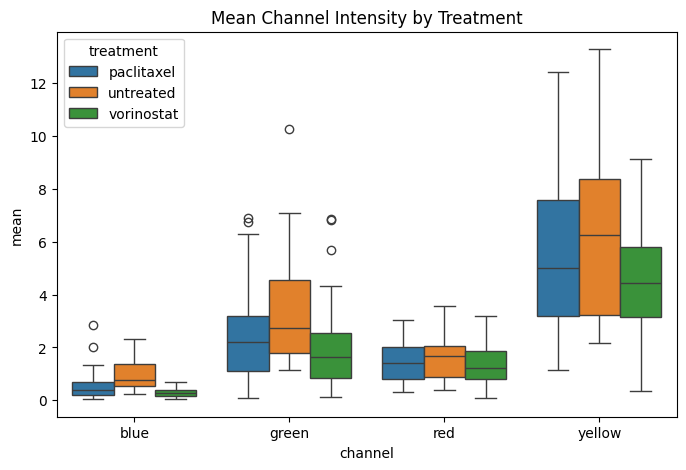

In [17]:
df_stats = compute_channel_stats_parallel(df_images)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_stats, x="channel", y="mean", hue="treatment")
plt.title("Mean Channel Intensity by Treatment")
plt.show()

    INSTALL CELLMAPS PIPELINE

In [18]:
!pip install cellmaps_pipeline

 GENERATE EMBEDDING WITH CELLMAPS_IMAGE_EMBEDDER

In [20]:
import os

from cellmaps_image_embedding.runner import DensenetEmbeddingGenerator
from cellmaps_image_embedding.runner import CellmapsImageEmbedder

input_base_path = r"C:/Users/bernalr3/Downloads/subset_if_images (1)/subset_if_images/data/raw"
image_interim_base_path = "C:/Users/bernalr3/Downloads/subset_if_images (1)/subset_if_images/data/pipeline_images"
embedding_base_path = "C:/Users/bernalr3/Downloads/subset_if_images (1)/subset_if_images/data/embedding"

for treatment_folder in os.listdir(input_base_path):
    input_path = os.path.join(input_base_path, treatment_folder)
    if not os.path.isdir(input_path):
        continue
    manifest_path = os.path.join(input_path, "manifest.csv")
    image_interim_path = os.path.join(image_interim_base_path, treatment_folder)
    embedding_path = os.path.join(embedding_base_path, treatment_folder)

    gen = DensenetEmbeddingGenerator(
        input_path,
        outdir=embedding_path,
        model_path="https://github.com/CellProfiling/densenet/releases/download/v0.1.0/external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds_fold0_final.pth",
        fold=1
    )
    embedder = CellmapsImageEmbedder(
        outdir=embedding_path,
        inputdir=input_path,
        embedding_generator=gen,
        name=f"{treatment_folder} IF Embedding",
        organization_name="CM4AI",
        project_name="CM4AI IF Embedding Tutorial"
    )
    embedder.run()

The project name for RO-Crate C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\raw\paclitaxel is missing from the metadata. Please provide a name to uphold FAIR principles. Execution will proceed without the  name.
The organization name for RO-Crate C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\raw\paclitaxel is missing from the metadata. Please provide a name to uphold FAIR principles. Execution will proceed without the  name.
Error occurred, but not raising exception due to raise_on_error flag set to False
Provenance call failed: {"cmd": ["c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\python.exe", "c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\fairscape-cli", "rocrate", "init", "--name", "paclitaxel IF Embedding", "--organization-name", "CM4AI", "--project-name", "CM4AI IF Embedding Tutorial", "--description", "AI artificial intelligence breast cancer cell maps CM4AI machine learning Paclitaxel IF Images IF 

load model: C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\embedding\paclitaxel\model.pth


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]
Error occurred, but not raising exception due to raise_on_error flag set to False
Provenance call failed: {"cmd": ["c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\python.exe", "c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\fairscape-cli", "rocrate", "register", "dataset", "--name", "cellmaps_image_embedding output file", "--version", "0.3.3", "--data-format", "tsv", "--description", "AI artificial intelligence breast cancer cell maps CM4AI machine learning Paclitaxel IF Images IF Image Embedding IF microscopy images embedding fold1 file", "--date-published", "2025-08-15", "--author", "cellmaps_image_embedding", "--keywords", "AI", "--keywords", "artificial intelligence", "--keywords", "breast cancer", "--keywords", "cell maps", "--keywords", "CM4AI", "--keywords", "machine learning", "--keywords", "Paclitaxel IF Images", "--keywords", "IF Image Embedding", "--keywords", "IF microscopy images", "--keywords", "e

load model: C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\embedding\untreated\model.pth


100%|██████████| 33/33 [00:11<00:00,  2.93it/s]
Error occurred, but not raising exception due to raise_on_error flag set to False
Provenance call failed: {"cmd": ["c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\python.exe", "c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\fairscape-cli", "rocrate", "register", "dataset", "--name", "cellmaps_image_embedding output file", "--version", "0.3.3", "--data-format", "tsv", "--description", "artificial intelligence breast cancer cell maps CM4AI machine learning MDA-MB-468 Untreated IF Image ROCrate IF Image Embedding IF microscopy images embedding fold1 file", "--date-published", "2025-08-15", "--author", "cellmaps_image_embedding", "--keywords", "artificial intelligence", "--keywords", "breast cancer", "--keywords", "cell maps", "--keywords", "CM4AI", "--keywords", "machine learning", "--keywords", "MDA-MB-468", "--keywords", "Untreated IF Image ROCrate", "--keywords", "IF Image Embedding", "--keywords", "IF microsco

load model: C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\embedding\vorinostat\model.pth


100%|██████████| 33/33 [00:10<00:00,  3.09it/s]
Error occurred, but not raising exception due to raise_on_error flag set to False
Provenance call failed: {"cmd": ["c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\python.exe", "c:\\Users\\bernalr3\\AppData\\Local\\anaconda3\\envs\\cm4ai\\fairscape-cli", "rocrate", "register", "dataset", "--name", "cellmaps_image_embedding output file", "--version", "0.3.3", "--data-format", "tsv", "--description", "AI artificial intelligence breast cancer cell maps CM4AI machine learning Vorinostat IF Image ROCrate IF Image Embedding IF microscopy images embedding fold1 file", "--date-published", "2025-08-15", "--author", "cellmaps_image_embedding", "--keywords", "AI", "--keywords", "artificial intelligence", "--keywords", "breast cancer", "--keywords", "cell maps", "--keywords", "CM4AI", "--keywords", "machine learning", "--keywords", "Vorinostat IF Image ROCrate", "--keywords", "IF Image Embedding", "--keywords", "IF microscopy images", "-

GENERATE A PROTEIN SIMILARITY GRAPH BASED ON THE EMBEDDING AND VISUALIZE RESULTS

In [21]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_distances
import ndex2
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
base_dir = r"C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\embedding"
output_path = r"C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\embedding_graph"
output_file = os.path.join(output_path, "if.cx")
os.makedirs(output_path, exist_ok=True)
G = nx.Graph()

In [23]:
def get_edge_dataframe(G):
    edge_data = []
    for u, v, attrs in G.edges(data=True):
        row = {"gene1": u, "gene2": v}
        row.update(attrs)
        edge_data.append(row)
    return pd.DataFrame(edge_data)

In [26]:
treatment_dfs = {}

for treatment in os.listdir(base_dir):
    treatment_path = os.path.join(base_dir, treatment)
    emb_file = os.path.join(treatment_path, "image_emd.tsv")

    if not os.path.isfile(emb_file):
        print(f"❌ Skipping {treatment}: image_emd.tsv not found.")
        continue

    print(f"🔍 Processing treatment: {treatment}")
    df = pd.read_csv(emb_file, sep="\t")
    df = df[df["id"].notna() & (df["id"] != "NEGATIVE")]
    embedding_cols = df.columns[1:]
    df[embedding_cols] = df[embedding_cols].apply(pd.to_numeric)

    # Average embeddings
    df_avg = df.groupby("id")[embedding_cols].mean().reset_index()
    treatment_dfs[treatment] = df_avg


🔍 Processing treatment: paclitaxel
🔍 Processing treatment: untreated
🔍 Processing treatment: vorinostat


In [27]:
# Get only genes common to all treatments
common_genes = set.intersection(*[set(df["id"]) for df in treatment_dfs.values()])
print(f"✅ Found {len(common_genes)} common genes across treatments")


✅ Found 5 common genes across treatments


In [28]:
for treatment, df_avg in treatment_dfs.items():
    df_avg = df_avg[df_avg["id"].isin(common_genes)].reset_index(drop=True)
    embedding_cols = df_avg.columns[1:]

    gene_names = df_avg["id"].tolist()
    emb_matrix = df_avg[embedding_cols].values
    distance_matrix = cosine_distances(emb_matrix)

    print(f"📐 Building cosine distance graph for {treatment}")
    for i in range(len(gene_names)):
        for j in range(i + 1, len(gene_names)):
            gene_i = gene_names[i]
            gene_j = gene_names[j]
            dist = distance_matrix[i, j]

            if not G.has_edge(gene_i, gene_j):
                G.add_edge(gene_i, gene_j)
            G[gene_i][gene_j][f"cosine_distance_{treatment}"] = dist

📐 Building cosine distance graph for paclitaxel
📐 Building cosine distance graph for untreated
📐 Building cosine distance graph for vorinostat


In [29]:
# Postprocessing: compute variability across treatments
print("📊 Computing variability in cosine distances across treatments...")

treatment_attrs = [attr for attr in next(iter(G.edges(data=True)))[-1] if attr.startswith("cosine_distance_")]

for u, v, data in G.edges(data=True):
    dists = [data.get(attr) for attr in treatment_attrs if data.get(attr) is not None]

    if len(dists) >= 2:  # Only calculate if we have at least 2 values
        data["cosine_distance_min"] = min(dists)
        data["cosine_distance_max"] = max(dists)
        data["cosine_distance_range"] = max(dists) - min(dists)
        data["cosine_distance_mean"] = sum(dists) / len(dists)
        data["cosine_distance_std"] = np.std(dists)
    else:
        # Set to None or 0 if not enough values
        data["cosine_distance_min"] = None
        data["cosine_distance_max"] = None
        data["cosine_distance_range"] = None
        data["cosine_distance_mean"] = None
        data["cosine_distance_std"] = None

📊 Computing variability in cosine distances across treatments...


In [30]:
ndex_graph = ndex2.create_nice_cx_from_networkx(G)

# Get the CX (list of CX aspects, not BytesIO)
cx_aspect_list = ndex_graph.to_cx()

# Save the CX JSON to a file
with open(output_file, "w") as f:
    json.dump(cx_aspect_list, f, indent=2)

print(f"✅ Graph saved to {output_file}")

Generating CX
✅ Graph saved to C:\Users\bernalr3\Downloads\subset_if_images (1)\subset_if_images\data\embedding_graph\if.cx


In [31]:
df_edges = get_edge_dataframe(G)

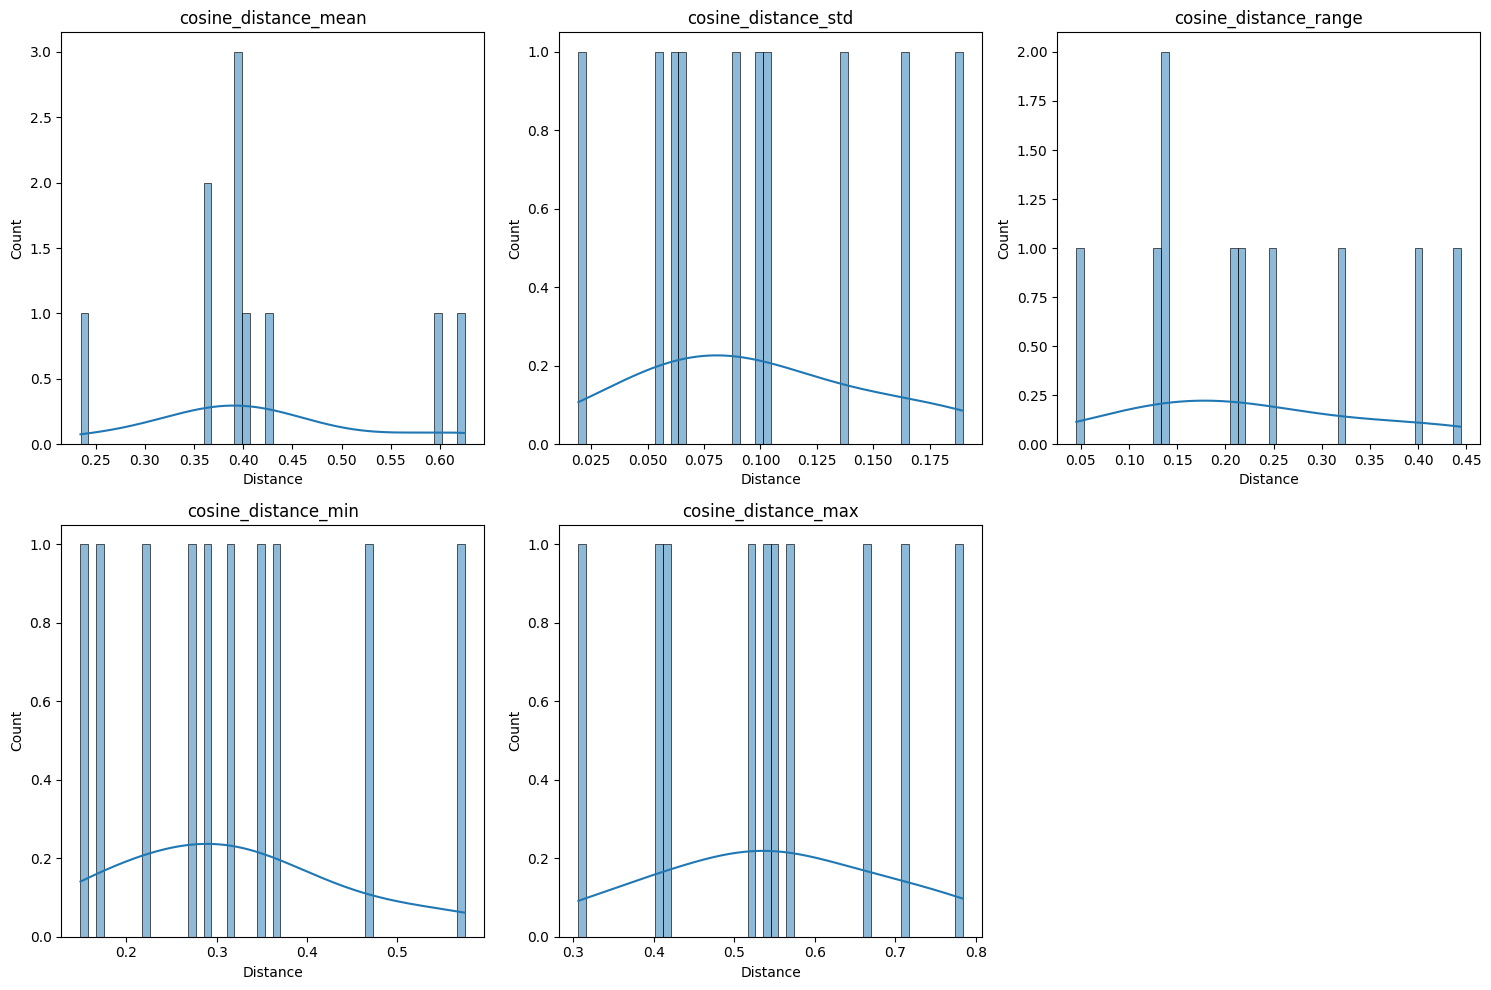

In [32]:
summary_metrics = [
    "cosine_distance_mean",
    "cosine_distance_std",
    "cosine_distance_range",
    "cosine_distance_min",
    "cosine_distance_max"
]

plt.figure(figsize=(15, 10))
for i, metric in enumerate(summary_metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_edges[metric].dropna(), bins=50, kde=True)
    plt.title(metric)
    plt.xlabel("Distance")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [33]:
print(df_edges[[
    "cosine_distance_min",
    "cosine_distance_max",
    "cosine_distance_mean",
    "cosine_distance_range",
    "cosine_distance_std"
]].describe())

       cosine_distance_min  cosine_distance_max  cosine_distance_mean  \
count            10.000000            10.000000             10.000000   
mean              0.317868             0.546803              0.420226   
std               0.130523             0.147223              0.114161   
min               0.149120             0.306446              0.234648   
25%               0.235544             0.441892              0.370690   
50%               0.300616             0.543195              0.397147   
75%               0.365066             0.641257              0.419029   
max               0.575064             0.783970              0.625471   

       cosine_distance_range  cosine_distance_std  
count              10.000000            10.000000  
mean                0.228935             0.098290  
std                 0.127023             0.052579  
min                 0.045254             0.019388  
25%                 0.136766             0.061285  
50%                 0.211149  

In [34]:
top_var = df_edges.sort_values("cosine_distance_std", ascending=False).head(10)
print("🔎 Top 10 most variable gene pairs across treatments:")
print(top_var[["gene1", "gene2", "cosine_distance_std", "cosine_distance_range"]])

🔎 Top 10 most variable gene pairs across treatments:
   gene1  gene2  cosine_distance_std  cosine_distance_range
0  HDAC8  KAT6B             0.189673               0.444308
1  HDAC8  KDM5C             0.164551               0.400746
5  KAT6B   MSL1             0.135213               0.319624
7  KDM5C   MSL1             0.104126               0.250380
8  KDM5C  PARP1             0.100545               0.216213
3  HDAC8  PARP1             0.089341               0.206086
9   MSL1  PARP1             0.064163               0.140953
4  KAT6B  KDM5C             0.060326               0.130418
6  KAT6B  PARP1             0.055570               0.135370
2  HDAC8   MSL1             0.019388               0.045254


PART II: HPA CELL SEGEMENTATION
-------------------------------------

NOTES: 
- The HPA Cell Segmentation will be run only with the first 10 images from PACLITAXEL medication and BLUE folder. This is for testing reasons. 
- If the HPA Cell Segmentation runs with the subset dataset (n=10) then run with the full sample/images. 
- Runs cell segmentation on images in the './data' folder using HPA-Cell-Segmentation. 
- Saves results to the './analysis' folder.

In [3]:
#INSTALL PACKAGES, IMAGING DEPS AND CLONES HPA_CELL_SEGMENTATION
import os
import sys
import glob
from pathlib import Path
import numpy as np
from PIL import Image
import imageio

!pip3 install scikit-image imageio scipy opencv-python pillow==6.2.1
!pip install git+https://github.com/haoxusci/pytorch_zoo@master#egg=pytorch_zoo
!pip3 install --upgrade torch

#!git clone https://github.com/CellProfiling/HPA-Cell-Segmentation.git
#%cd HPA-Cell-Segmentation

!sh install.sh
!python -c "import hpacellseg"

  Cloning https://github.com/haoxusci/pytorch_zoo (to revision master) to c:\users\bernalr3\appdata\local\temp\pip-install-vq7r4ko1\pytorch-zoo_b303b670e5344606bac638ae2349fe6f
  Resolved https://github.com/haoxusci/pytorch_zoo to commit e7f30cd9d2e900439f98d250ac309caf03a166b4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/haoxusci/pytorch_zoo 'C:\Users\bernalr3\AppData\Local\Temp\pip-install-vq7r4ko1\pytorch-zoo_b303b670e5344606bac638ae2349fe6f'


sh: install.sh: No such file or directory


In [4]:
!git clone https://github.com/CellProfiling/HPA-Cell-Segmentation.git
%cd HPA-Cell-Segmentation

fatal: destination path 'HPA-Cell-Segmentation' already exists and is not an empty directory.

c:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\HPA-Cell-Segmentation


In [5]:
#!/usr/bin/env python3
"""
HPA-Cell-Segmentation Script
Runs nuclei segmentation on images in DATA_DIR using HPA-Cell-Segmentation
and saves results to ANALYSIS_DIR/segmentation_results.

Edit the three USER PATHS below to match your machine.
"""

import sys
from pathlib import Path
import numpy as np
from PIL import Image
import imageio

# ---- NumPy compatibility shim for older code (NumPy >=1.24 removed these) ----
if not hasattr(np, "bool"):  np.bool  = np.bool_
if not hasattr(np, "int"):   np.int   = np.int_
if not hasattr(np, "float"): np.float = np.float64
# -----------------------------------------------------------------------------

# ========= USER PATHS (update if you move things) =========
HPA_PATH     = Path(r"C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\HPA-Cell-Segmentation")
DATA_DIR     = Path(r"C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\data\blue")
ANALYSIS_DIR = Path(r"C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis")
# ==========================================================

# Try to import hpacellseg; if not installed, load from the clone at HPA_PATH
try:
    import hpacellseg.cellsegmentator as cellsegmentator
    from hpacellseg.utils import label_nuclei
except ImportError:
    if (HPA_PATH / "hpacellseg").exists():
        sys.path.insert(0, str(HPA_PATH))
        import hpacellseg.cellsegmentator as cellsegmentator
        from hpacellseg.utils import label_nuclei
    else:
        raise ImportError(
            "Cannot import hpacellseg. Either install it with:\n"
            f'  pip install -e "{HPA_PATH}"\n'
            "or update HPA_PATH to your clone."
        )

def load_image(image_path: str):
    """Load image and convert to numpy array, ensuring 3 channels if needed."""
    try:
        img = Image.open(image_path)
        arr = np.array(img)
        if arr.ndim == 2:  # grayscale -> stack to 3 channels
            arr = np.stack([arr, arr, arr], axis=2)
        elif arr.ndim == 3 and arr.shape[2] == 1:
            arr = np.concatenate([arr, arr, arr], axis=2)
        elif arr.ndim == 3 and arr.shape[2] == 3:
            pass  # RGB OK
        else:
            print(f"Warning: Unexpected format for {image_path}: {arr.shape}")
            return None
        return arr
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def main():
    # Prepare folders
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)
    output_dir = ANALYSIS_DIR / "segmentation_results"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Gather images (non-recursive; add '**/*' if you need recursive)
    exts = ('*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff')
    image_files = [str(p) for ext in exts for p in DATA_DIR.glob(ext)]

    if not image_files:
        print(f"No image files found in: {DATA_DIR}")
        return
    print(f"Found {len(image_files)} images to process")

    # Model weights (let hpacellseg auto-download if missing)
    nuclei_model_path = ANALYSIS_DIR / "nuclei_model.pth"
    cell_model_path   = ANALYSIS_DIR / "cell_model.pth"

    # If OneDrive left zero-byte placeholders, delete to force re-download
    for p in (nuclei_model_path, cell_model_path):
        if p.exists() and p.stat().st_size < 1024:
            print(f"{p.name} looks like a placeholder (size < 1KB); deleting to trigger re-download.")
            p.unlink()

    # Choose device
    try:
        import torch
        device = "cuda" if torch.cuda.is_available() else "cpu"
    except Exception:
        device = "cpu"
    print("Using device:", device)

    # Initialize segmentator (will auto-download weights if missing)
    print("Initializing CellSegmentator...")
    segmentator = cellsegmentator.CellSegmentator(
        str(nuclei_model_path),
        str(cell_model_path),
        scale_factor=0.25,
        device=device,
        padding=True,
        multi_channel_model=False
    )
    print("CellSegmentator initialized")

    # Process images
    for i, image_path in enumerate(image_files, 1):
        print(f"\nProcessing {i}/{len(image_files)}: {Path(image_path).name}")
        arr = load_image(image_path)
        if arr is None:
            continue

        # Nuclei segmentation
        preds = segmentator.pred_nuclei([arr])
        if not preds:
            print("  No nuclei predictions produced")
            continue

        nuclei_mask = label_nuclei(preds[0])

        # Save results
        base = Path(image_path).stem
        mask_path = output_dir / f"{base}_nuclei_mask.png"
        pred_path = output_dir / f"{base}_nuclei_prediction.npy"

        imageio.imwrite(str(mask_path), nuclei_mask.astype(np.uint16))
        np.save(str(pred_path), preds[0])

        n_labels = len(np.unique(nuclei_mask)) - 1  # minus background
        print(f"  Saved mask: {mask_path}")
        print(f"  Saved raw pred: {pred_path}")
        print(f"  Detected nuclei: {n_labels}")

    print(f"\nDone. Results in: {output_dir}")

    # Summary file
    summary = output_dir / "segmentation_summary.txt"
    with open(summary, "w") as f:
        f.write("HPA-Cell-Segmentation Results Summary\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Total images processed: {len(image_files)}\n")
        f.write(f"Output directory: {output_dir}\n")
        f.write("Models: nuclei_model.pth, cell_model.pth\n")
        f.write("Scale factor: 0.25 | Device: " + device.upper() + " | Padding: True | Multi-channel: False\n\n")
        f.write("Files generated:\n")
        for ext in ('*_nuclei_mask.png', '*_nuclei_prediction.npy'):
            for p in output_dir.glob(ext):
                f.write(f"  {p.name}\n")

if __name__ == "__main__":
    main()
### Results in: C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\segmentation_results

Found 10 images to process
Using device: cpu
Initializing CellSegmentator...
CellSegmentator initialized

Processing 1/10: B2AI_1_Paclitaxel_A1_R2_z01_blue.jpg
  Saved mask: C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\segmentation_results\B2AI_1_Paclitaxel_A1_R2_z01_blue_nuclei_mask.png
  Saved raw pred: C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\segmentation_results\B2AI_1_Paclitaxel_A1_R2_z01_blue_nuclei_prediction.npy
  Detected nuclei: 74

Processing 2/10: B2AI_1_Paclitaxel_A1_R5_z01_blue.jpg
  Saved mask: C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\segmentation_results\B2AI_1_Paclitaxel_A1_R5_z01_blue_nuclei_mask.png
  Saved raw pred: C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\segmentation_results\B2AI_1_Paclitaxel_A1_R5_z01_blue_nuclei_prediction.npy
  Detected nuclei: 35

Processing 3/10: B2AI_1_Pacl

HPS Cell Segmentation with multiple channels
---

NOTES: 
- Matches red/yellow/blue images by basename across folders.
- Converts each to grayscale, stacks into a 3-channel (R,Y,B) image.
- Auto-downloads nuclei/cell model weights if missing and selects CPU/GPU.
- Runs hpacellseg for nuclei and cell segmentation (multi-channel).
- Saves nuclei/cell masks (PNG) and raw predictions (NPY) + a summary in analysis/segmentation_results2.

Trial 1: 

In [5]:
#!/usr/bin/env python3
"""
HPA-Cell-Segmentation Script (multi-channel, RGB->grayscale fix)
- Matches red (microtubules), yellow (ER), blue (nuclei) by normalized basename
- Converts each channel image to grayscale and stacks as HxWx3 (R,Y,B)
- Runs nuclei + cell segmentation and saves masks/predictions

Assumes folders:
  DATA_ROOT/red, DATA_ROOT/yellow, DATA_ROOT/blue
The green channel (protein) is ignored by hpacellseg.

Edit the USER PATHS below to match your machine.
"""

import re
import sys
from pathlib import Path

import numpy as np
from PIL import Image
import imageio

# ------------ Quiet noisy dependency warnings (optional, safe) ------------
import warnings
warnings.filterwarnings("ignore", message=".*multichannel.*", category=FutureWarning)
try:
    from torch.serialization import SourceChangeWarning
    warnings.filterwarnings("ignore", category=SourceChangeWarning)
except Exception:
    pass
warnings.filterwarnings("ignore", message=".*weights_only=False.*", category=FutureWarning)
# --------------------------------------------------------------------------

# ---- NumPy compatibility shim (NumPy >=1.24 removed legacy aliases) ----
if "bool"  not in np.__dict__: np.bool  = np.bool_
if "int"   not in np.__dict__: np.int   = np.int_
if "float" not in np.__dict__: np.float = np.float64
# ------------------------------------------------------------------------

# ===================== USER PATHS (update these) =====================
HPA_PATH     = Path(r"C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\HPA-Cell-Segmentation")
DATA_ROOT    = Path(r"C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\data")
ANALYSIS_DIR = Path(r"C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis")
# =====================================================================

# Try import from installed package; otherwise import from local clone
try:
    import hpacellseg.cellsegmentator as cellsegmentator
    from hpacellseg.utils import label_nuclei, label_cell
except ImportError:
    if (HPA_PATH / "hpacellseg").exists():
        sys.path.insert(0, str(HPA_PATH))
        import hpacellseg.cellsegmentator as cellsegmentator
        from hpacellseg.utils import label_nuclei, label_cell
    else:
        raise ImportError(
            "Cannot import hpacellseg. Either install it with:\n"
            f'  pip install -e "{HPA_PATH}"\n'
            "or update HPA_PATH to your clone."
        )

def list_images(folder: Path):
    exts = ('.tif', '.tiff', '.png', '.jpg', '.jpeg')
    return [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in exts]

# Strip common channel tokens so files can be matched by basename
CHANNEL_TOKENS = re.compile(
    r'(?i)(?:^|[_\-\s])('
    r'red|r|microtubules?|mtub|tubulin|tub|'
    r'yellow|yel|y|er|reticulum|'
    r'blue|b|nuclei|nuc|dapi|dna|'
    r'ch(?:an(?:nel)?)?_?\d{1,2}'
    r')(?=$|[_\-\s])'
)

def normalize_key(path: Path):
    s = path.stem.lower()
    s = CHANNEL_TOKENS.sub('', s)
    s = re.sub(r'[_\-\s]+', '_', s).strip('_')
    return s

def natural_key(s: str):
    return [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', s)]

def read_gray(path: Path, target_shape=None):
    """Load image, convert to grayscale (L), return 2D uint8; resize to target_shape=(H,W) if provided."""
    img = Image.open(path).convert('L')  # force single channel
    if target_shape is not None and img.size != (target_shape[1], target_shape[0]):  # PIL size=(W,H)
        img = img.resize((target_shape[1], target_shape[0]), resample=Image.BILINEAR)
    return np.array(img)

def main():
    ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)
    out_dir = ANALYSIS_DIR / "segmentation_results2"
    out_dir.mkdir(parents=True, exist_ok=True)

    red_dir    = DATA_ROOT / "red"     # microtubules
    yellow_dir = DATA_ROOT / "yellow"  # ER
    blue_dir   = DATA_ROOT / "blue"    # nuclei (DAPI)

    for d in (red_dir, yellow_dir, blue_dir):
        d.mkdir(parents=True, exist_ok=True)

    red_list    = list_images(red_dir)
    yellow_list = list_images(yellow_dir)
    blue_list   = list_images(blue_dir)

    print(f"Counts — red: {len(red_list)}, yellow: {len(yellow_list)}, blue: {len(blue_list)}")

    # Build maps by normalized key
    def build_map(paths):
        m = {}
        for p in paths:
            k = normalize_key(p)
            m.setdefault(k, []).append(p)
        return m

    red_map    = build_map(red_list)
    yellow_map = build_map(yellow_list)
    blue_map   = build_map(blue_list)

    common_keys = sorted(set(red_map) & set(yellow_map) & set(blue_map), key=natural_key)
    if not common_keys:
        print("No matched (red, yellow, blue) triplets after normalization.")
        # Debug a few keys to help user adjust tokens
        for name, m in (("red", red_map), ("yellow", yellow_map), ("blue", blue_map)):
            print(f"Sample normalized keys for {name}:", list(m.keys())[:5])
        return

    print(f"Matched {len(common_keys)} triplets (red/yellow/blue).")

    # Prepare grayscale arrays and precombined HxWx3 stacks (R=red, Y=yellow, B=blue)
    combined_cells = []  # list of HxWx3 uint8
    nuc_grays      = []  # list of HxW uint8
    stems          = []

    for k in common_keys:
        r_path = sorted(red_map[k],    key=lambda p: natural_key(p.name))[0]
        y_path = sorted(yellow_map[k], key=lambda p: natural_key(p.name))[0]
        b_path = sorted(blue_map[k],   key=lambda p: natural_key(p.name))[0]

        # Read nuclei first to set target size
        b_gray = read_gray(b_path)
        r_gray = read_gray(r_path, target_shape=b_gray.shape)
        y_gray = read_gray(y_path, target_shape=b_gray.shape)

        combo = np.stack([r_gray, y_gray, b_gray], axis=2)  # HxWx3
        combined_cells.append(combo)
        nuc_grays.append(b_gray)
        stems.append(k if k else b_path.stem)

    # Model weights (auto-download if missing; delete zero-byte placeholders)
    nuclei_model_path = ANALYSIS_DIR / "nuclei_model.pth"
    cell_model_path   = ANALYSIS_DIR / "cell_model.pth"
    for p in (nuclei_model_path, cell_model_path):
        if p.exists() and p.stat().st_size < 1024:
            print(f"{p.name} looks like a zero-byte placeholder; deleting to trigger re-download.")
            p.unlink()

    # Device
    try:
        import torch
        device = "cuda" if torch.cuda.is_available() else "cpu"
    except Exception:
        device = "cpu"
    print("Using device:", device)

    # Initialize multi-channel model
    print("Initializing CellSegmentator (multi_channel_model=True)...")
    segmentator = cellsegmentator.CellSegmentator(
        str(nuclei_model_path),
        str(cell_model_path),
        scale_factor=0.25,
        device=device,
        padding=True,
        multi_channel_model=True
    )
    print("CellSegmentator initialized")

    # Run segmentation
    print("Running nuclei predictions...")
    nuc_preds  = segmentator.pred_nuclei(nuc_grays)  # pass 2D arrays
    print("Running cell predictions (precombined RGB stacks)...")
    cell_preds = segmentator.pred_cells(combined_cells, precombined=True)  # <-- key change

    # Save results
    for i, stem in enumerate(stems, 1):
        print(f"\nPost-processing {i}/{len(stems)}: {stem}")

        nuc_mask = label_nuclei(nuc_preds[i-1])
        nuclei_mask, cell_mask = label_cell(nuc_preds[i-1], cell_preds[i-1])

        nuc_mask_png  = out_dir / f"{stem}_nuclei_mask.png"
        cell_mask_png = out_dir / f"{stem}_cell_mask.png"
        nuc_pred_npy  = out_dir / f"{stem}_nuclei_prediction.npy"
        cell_pred_npy = out_dir / f"{stem}_cell_prediction.npy"

        imageio.imwrite(str(nuc_mask_png),  nuc_mask.astype(np.uint16))
        imageio.imwrite(str(cell_mask_png), cell_mask.astype(np.uint16))
        np.save(str(nuc_pred_npy),  nuc_preds[i-1])
        np.save(str(cell_pred_npy), cell_preds[i-1])

        print(f"  Saved masks: {nuc_mask_png.name}, {cell_mask_png.name}")

    # Summary
    summary = out_dir / "segmentation_summary.txt"
    with open(summary, "w") as f:
        f.write("HPA-Cell-Segmentation Results Summary (multi-channel, grayscale-fixed)\n")
        f.write("=" * 70 + "\n\n")
        f.write(f"Matched triplets: {len(stems)}\n")
        f.write(f"Data root: {DATA_ROOT}\nOutput dir: {out_dir}\n")
        f.write("Channels used: red(microtubules)=R, yellow(ER)=Y, blue(nuclei)=B; green ignored.\n")
        f.write("Models: nuclei_model.pth, cell_model.pth\n")
        f.write(f"Scale factor: 0.25 | Device: {device.upper()} | Padding: True | Multi-channel: True\n")

    print(f"\nDone. Results in: {out_dir}")

if __name__ == "__main__":
    main()
### Results in: C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\segmentation_results2

Counts — red: 10, yellow: 10, blue: 10
Matched 10 triplets (red/yellow/blue).
Using device: cpu
Initializing CellSegmentator (multi_channel_model=True)...
CellSegmentator initialized
Running nuclei predictions...
Running cell predictions (precombined RGB stacks)...

Post-processing 1/10: b2ai_1_paclitaxel_a1_r2_z01
  Saved masks: b2ai_1_paclitaxel_a1_r2_z01_nuclei_mask.png, b2ai_1_paclitaxel_a1_r2_z01_cell_mask.png

Post-processing 2/10: b2ai_1_paclitaxel_a1_r5_z01
  Saved masks: b2ai_1_paclitaxel_a1_r5_z01_nuclei_mask.png, b2ai_1_paclitaxel_a1_r5_z01_cell_mask.png

Post-processing 3/10: b2ai_1_paclitaxel_a1_r6_z01
  Saved masks: b2ai_1_paclitaxel_a1_r6_z01_nuclei_mask.png, b2ai_1_paclitaxel_a1_r6_z01_cell_mask.png

Post-processing 4/10: b2ai_1_paclitaxel_a2_r5_z01
  Saved masks: b2ai_1_paclitaxel_a2_r5_z01_nuclei_mask.png, b2ai_1_paclitaxel_a2_r5_z01_cell_mask.png

Post-processing 5/10: b2ai_1_paclitaxel_a2_r7_z01
  Saved masks: b2ai_1_paclitaxel_a2_r7_z01_nuclei_mask.png, b2ai_1_pacl

c:\Users\bernalr3\AppData\Local\anaconda3\envs\cm4ai\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


  Saved masks: b2ai_1_paclitaxel_a2_r12_z01_nuclei_mask.png, b2ai_1_paclitaxel_a2_r12_z01_cell_mask.png

Post-processing 8/10: b2ai_1_paclitaxel_a2_r14_z01
  Saved masks: b2ai_1_paclitaxel_a2_r14_z01_nuclei_mask.png, b2ai_1_paclitaxel_a2_r14_z01_cell_mask.png

Post-processing 9/10: b2ai_1_paclitaxel_a2_r17_z01
  Saved masks: b2ai_1_paclitaxel_a2_r17_z01_nuclei_mask.png, b2ai_1_paclitaxel_a2_r17_z01_cell_mask.png

Post-processing 10/10: b2ai_1_paclitaxel_a2_r18_z01
  Saved masks: b2ai_1_paclitaxel_a2_r18_z01_nuclei_mask.png, b2ai_1_paclitaxel_a2_r18_z01_cell_mask.png

Done. Results in: C:\Users\bernalr3\OneDrive - UT Health San Antonio\Archive\Documents\CM4AI - WG\analysis\segmentation_results2
